# Pascal VOC - Multi label classification

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [5]:
torch.backends.cudnn.benchmark = True

## Setup

**Globals**

In [15]:
print("categories json:", trn_j[CATEGORIES][0])
print("images json:", trn_j[IMAGES][0])
print("annotations json:", trn_j[ANNOTATIONS][0])

categories json: {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}
images json: {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}
annotations json: {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}


In [8]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [16]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [21]:
print(len(cats), len(trn_fns), len(trn_ids))

20 2501 2501


In [22]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH / JPEGS

In [23]:
IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [29]:
!ls {str(IMG_PATH)} | wc -l

5011


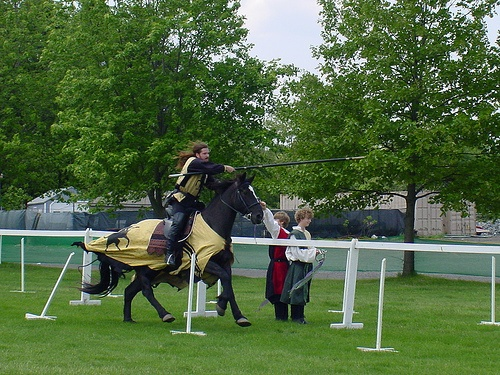

In [28]:
# DEBUG: try to show an image from the dataset in file system
from IPython.display import Image
Image(filename=str(IMG_PATH / '000009.jpg'))

**Define Common Functions**

Very similar to the first Pascal model (single object detection).

In [30]:
def hw_bb(bb):
    # Example, bb = [155, 96, 196, 174]
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

In [31]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])

    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX] # one bbox. looks like '[155, 96, 196, 174]'.
            bb = hw_bb(bb)
            trn_anno[o[IMG_ID]].append( (bb, o[CAT_ID]) )
    return trn_anno

In [42]:
trn_anno = get_trn_anno()
len(trn_anno)

2501

In [32]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [33]:
def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

In [34]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [35]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [36]:
def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

In [37]:
def draw_im(im, ann):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        # b is bbox, c is class id
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [38]:
def draw_idx(i):
    # i is image id
    im_a = trn_anno[i] # training annotations
    im = open_image(IMG_PATH / trn_fns[i]) # trn_fns is training image file names
    draw_im(im, im_a) # im_a is an element of annotation

## Multi class

**Setup**

In [39]:
MC_CSV = PATH / 'tmp/mc.csv'

In [43]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [44]:
mc = [ set( [cats[p[1]] for p in trn_anno[o] ] ) for o in trn_ids ]
mcs = [ ' '.join( str(p) for p in o ) for o in mc ] # stringify mc

In [51]:
print('mc:', mc[1])
print('mcs:', mcs[1])

mc: {'horse', 'person'}
mcs: horse person


In [52]:
df = pd.DataFrame({ 'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs }, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [54]:
# DEBUG: Check CSV file is created
!ls {str(PATH)}/tmp/

bb.csv	lrg.csv  mc.csv


In [55]:
# DEBUG: View CSV data
!head -n 10 {str(PATH)}/tmp/mc.csv

fn,clas
000012.jpg,car
000017.jpg,horse person
000023.jpg,person bicycle
000026.jpg,car
000032.jpg,person aeroplane
000033.jpg,aeroplane
000034.jpg,train
000035.jpg,person
000036.jpg,dog


### Model

Setup ResNet model and train.

In [57]:
f_model = resnet34
sz = 224
bs = 64

In [58]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [60]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [61]:
lrf = learn.lr_find(1e-5, 100)

epoch      trn_loss   val_loss   <lambda>                  
    0      1.705616   11.417138  0.5868    



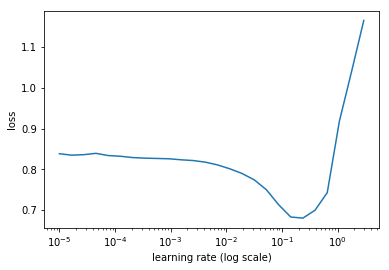

In [62]:
learn.sched.plot(0)

In [63]:
lr = 2e-2

In [64]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.319539   0.139347   0.9535    
    1      0.172275   0.080689   0.9724                    
    2      0.116136   0.075965   0.975                     



[array([0.07597]), 0.9750000004768371]

In [65]:
# Define learning rates to search
lrs = np.array([lr/100, lr/10, lr])

In [66]:
# Freeze the model till the last 2 layers as before
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s, loss=0.464] 

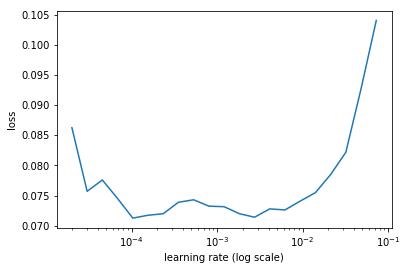

In [67]:
# Find the optimal learning rate again
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [68]:
# Refit the model
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.071997   0.078266   0.9734    
    1      0.055321   0.082668   0.9737                     
    2      0.040407   0.077682   0.9757                     
    3      0.027939   0.07651    0.9756                     
    4      0.019983   0.07676    0.9763                     


[array([0.07676]), 0.9763000016212463]

Save the model

In [69]:
learn.save('mclas')

In [70]:
learn.load('mclas')

### Evaluate

In [71]:
y = learn.predict()
x, _ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


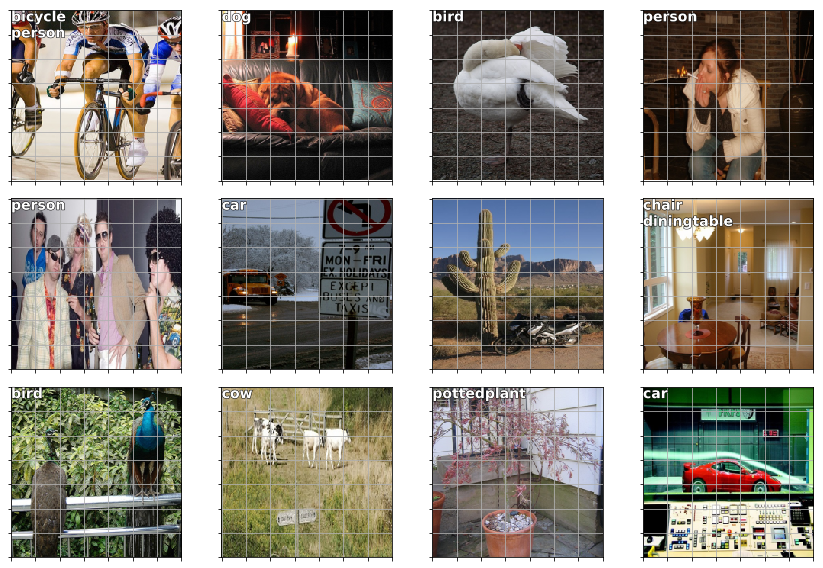

In [72]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()

## Multiple bounding box (bbox) per cell

### Set up data

In [74]:
CLAS_CSV = PATH / 'tmp/clas.csv'
MBB_CSV = PATH / 'tmp/mbb.csv'

f_model = resnet34
sz = 224
bs = 64

Create lookups and reference objects.

- `mc` - list of items found per image.
- `mcs` - list of items found per image, but the ID.
- `id2cat` - numeric value to category.
- `cat2id` - category to id.

In [75]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]

In [419]:
# DEBUG: inspect mc variable
mc[4]

['aeroplane', 'aeroplane', 'person', 'person']

In [86]:
id2cat = list(cats.values())

In [93]:
cat2id = { v: k for k, v in enumerate(id2cat) }

In [102]:
mcs = np.array([ np.array([ cat2id[p] for p in o ]) for o in mc ])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [440]:
mcs[4] # returns ['aeroplane', 'aeroplane', 'person', 'person']

array([ 0,  0, 14, 14])

In [97]:
# DEBUG: inspect cats variable
cats[4], id2cat[3], cat2id['boat']

('boat', 'boat', 3)

In [104]:
# Get cross validation ids
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs), ) = split_by_idx(val_idxs, mcs)

Create and save multiple bounding boxes.

In [131]:
mbb = [ np.concatenate( [ p[0] for p in trn_anno[o] ] ) for o in trn_ids]

In [129]:
# DEBUG: inspect trn_anno dict
trn_anno[12][0]

(array([ 96, 155, 269, 350]), 7)

In [141]:
mbb[12].shape, mbb[12]

((8,), array([106,  57, 464, 290,   0,   1, 499, 301]))

In [142]:
mbbs = [ ' '.join( str(p) for p in o ) for o in mbb ]

In [143]:
mbbs[12]

'106 57 464 290 0 1 499 301'

In [144]:
df = pd.DataFrame({ 'fn': [ trn_fns[o] for o in trn_ids ], 'bbox': mbbs }, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [146]:
# DEBUG: check CSV file is created in file system
!ls {PATH}/tmp

bb.csv	lrg.csv  mbb.csv  mc.csv


In [147]:
# DEBUG: view CSV data
!head -n 10 {PATH / 'tmp/mbb.csv'}

fn,bbox
000012.jpg,96 155 269 350
000017.jpg,61 184 198 278 77 89 335 402
000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 461 242 0 224 485 333
000026.jpg,124 89 211 336
000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 188 25 237 43
000033.jpg,106 8 262 498 199 420 225 481 187 324 222 410
000034.jpg,166 115 399 359 152 140 228 332
000035.jpg,95 0 360 190 97 217 317 464
000036.jpg,78 26 343 318


In [148]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

Setup dataset.

In [149]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

### Setup some plotting functions

In [150]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

In [151]:
def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [152]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [448]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    # bb = [bb_hw(o) for o in bbox.reshape(-1, 4)]
    
    bb = []
    # if all the elements of the array are zero, then ignore them
    # Bug fix? http://forums.fast.ai/t/part-2-lesson-9-wiki/14028/458?u=cedric
    for o in bbox.reshape(-1, 4):
        # reshape numpy.ndarray with shape: (56,) to (dim, 4). in this case, it's (18, 4)
        if np.all(o == np.zeros(4)) == False:
            bb.append(bb_hw(o))
    
    if prs is None:
        prs = [None] * len(bb)
    if clas is None:
        # clas has shape (14,). e.g.: [ 0  0  0  0  0  0  0  0  0  0  0  1 14 14]
        clas = [None] * len(bb)
    else:
        # get non-zero values from array. e.g.: [1 14 14]
        clas = clas[-len(bb):]
    
    ax = show_img(im, ax=ax)
    
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
#         print('=============================')
#         print(f'b: {b}')
#         print(f'c: {c}')
#         print(f'pr: {pr}')
        if((b[2] > 0) and (pr is None or pr > thresh)):
            # b[2] > 2 means check if bbox is a square/rectangular, not a line.
            draw_rect(ax, b, color=colr_list[i % num_colr])
            txt = f'{i} '
#             print('txt:', txt)
            if c is not None:
                txt += ('bg' if c == len(id2cat) else id2cat[c])
                # txt += ('bg' if c == 0 else id2cat[c])
#                 print('c txt:', txt)
            if pr is not None:
                txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i % num_colr])

In [362]:
id2cat[0], id2cat[1], id2cat[12], id2cat[13], id2cat[19]

('aeroplane', 'bicycle', 'horse', 'motorbike', 'tvmonitor')

### Create dataset with 2 associated labels.

In [154]:
class ConcatLblDataset(Dataset):
    """
    A dataset that adds a second label to an existing dataset.
    """

    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i])) # (image, (bbox, classes))

In [155]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs) # val_mcs -> y2 <- list of items found per image, but the ID.
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

### View the sample labels

For validation dataset

In [378]:
x, y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

In [478]:
# ============================== START DEBUG ==============================
i = 0
# image
print(x[i].shape) # type: numpy.ndarray, shape: (224, 224, 3) ==> an image
# bbox - y type: list, y len: 2
print('')
print(y[0].shape) # y[0] type: list of numpy.ndarray, y[0] shape: (64, 56)
print(y[0][i].shape) # y[0][i] type: numpy.ndarray, shape: (56,)
print(y[0][i])
# class
print('')
print(y[1].shape) # y[1] type: list of numpy.ndarray, y[1] shape: (64, 14)
print(y[1][i].shape) # y[1][i] type: numpy.ndarray, shape: (14,)
print(y[1][i])
# ============================== END DEBUG ==============================

(224, 224, 3)

(64, 56)
(56,)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  91.  47. 223. 169.   0.  49. 205. 180.   9. 169. 217. 222.]

(64, 14)
(14,)
[ 0  0  0  0  0  0  0  0  0  0  0  1 14 14]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


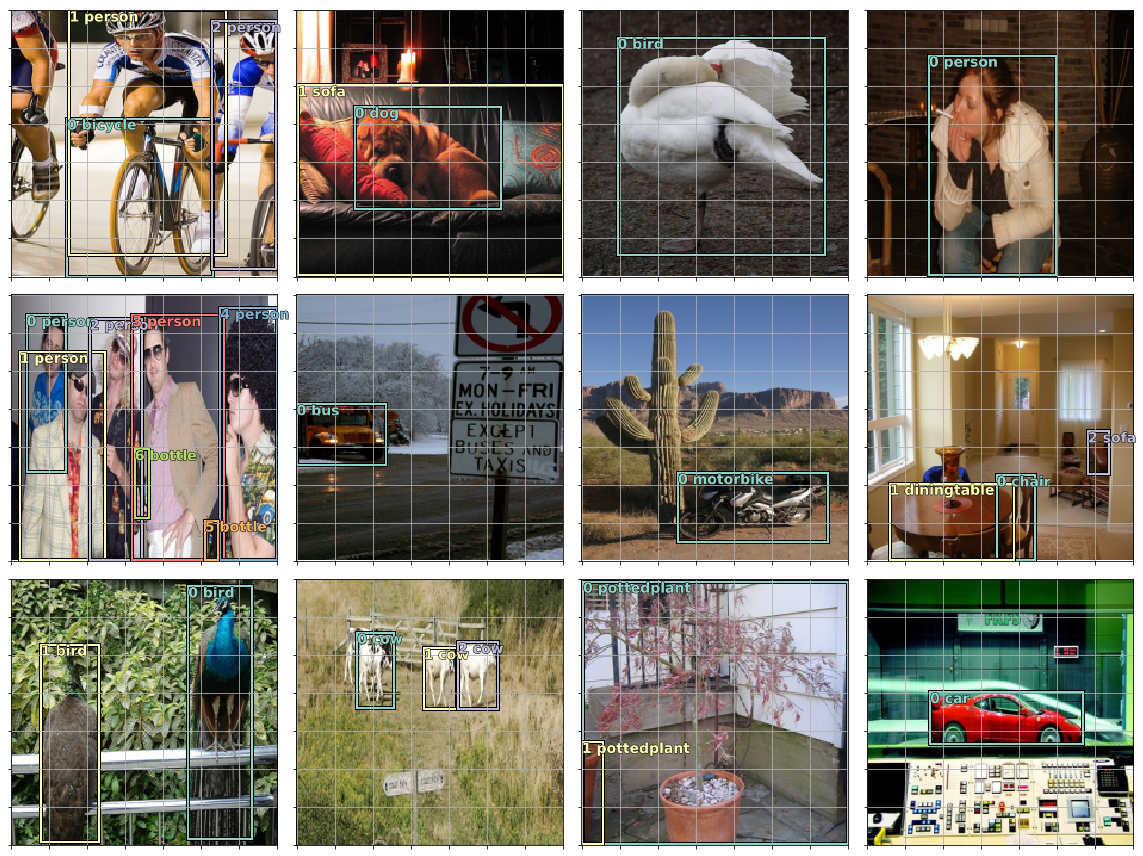

In [479]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

For training dataset

In [480]:
x, y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


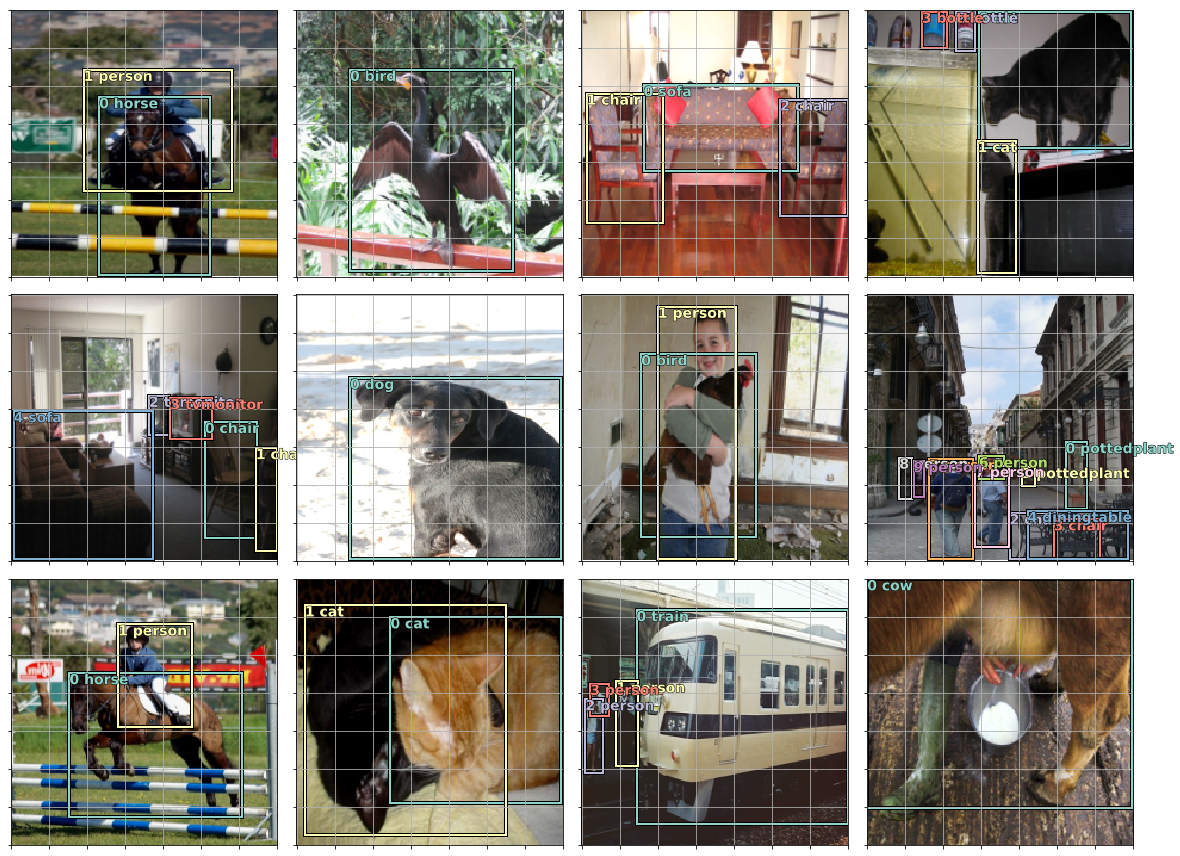

In [481]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Make a model to predict what shows up in a 4x4 grid

### Set up model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

Anchor Grid

- `anc_grid`: how big of a square grid to make (subdivision)
- `anc_offset`: center offsets
- `anc_x`: x coordinates for centers
- `anc_y`: y coordinates for centers
- `anc_ctrs`: the actual coordinates for the grid centers
- `anc_sizes`: size of the quadrants

In [486]:
anc_grid = 4
k = 1

anc_offset = 1 / (anc_grid * 2)
anc_x = np.repeat(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1))
anc_sizes = np.array([ [ 1 / anc_grid, 1 / anc_grid ] for i in range(anc_grid * anc_grid) ])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float() # convert LongTensor to FloatTensor

_Note to self: difference between numpy concatenate and stack_
- _numpy concatenate join a sequence of arrays along an **existing axis**._
- _numpy stack join a sequence of arrays along a **new axis**._

In [483]:
# ================= DEBUG =================
# np.concatenate([anc_ctrs, anc_sizes], axis=1)
anc_ctrs = np.array([[1, 2], [3, 4]]) # example of 2 center points
anc_sizes = np.array([[5], [6]]) # example of size for each point

# print(arr_two.T)
concat_ctrs_sz = np.concatenate([anc_ctrs, anc_sizes], axis=1)
print(concat_ctrs_sz)
print('')
print(V(concat_ctrs_sz, requires_grad=False).float())

# np.stack([anc_x, anc_y], axis=1)
anc_x = np.array([1, 2, 3])
anc_y = np.array([2, 3, 4])
stack_x_y = np.stack([anc_x, anc_y], axis=1)
print(stack_x_y)
# ================= END DEBUG =================

[[1 2 5]
 [3 4 6]]

Variable containing:
 1  2  5
 3  4  6
[torch.cuda.FloatTensor of size 2x3 (GPU 0)]

[[1 2]
 [2 3]
 [3 4]]


In [487]:
# unsqueeze is like TF add_dims, add dimension to a tensor.
# from tensor size 1 to size 1x1
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

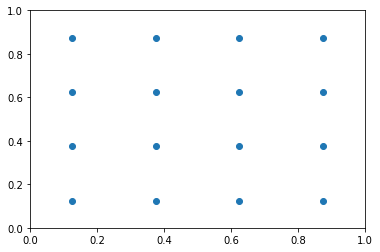

In [488]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [489]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [490]:
def hw2corners(ctr, hw):
    return torch.cat([ctr - hw / 2, ctr + hw / 2], dim=1)

In [491]:
# anchors[:, :2] # first 2 columns (which is where the center coords are)
# anchors[:, 2:] # all columns after the second one (which is where the height & width are)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [492]:
n_clas = len(id2cat) + 1 # plus 1 for the background (bg) class
n_act = k * (4 + n_clas) # 1 * (4 + 21)
n_act

25

### Build a simple convolutional model

In [493]:
class StdConv(nn.Module):
    """
    A combination block of Conv2d, BatchNorm, Dropout
    """
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

In [494]:
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf//k)

This is an output convolutional model with 2 `Conv2d` layers.

In [495]:
class OutConv(nn.Module):
    """
    A combination block of `Conv2d`, `4 x Stride 1`, `Conv2d`, `C x Stride 1` with two layers.
    
    We are outputting `4 + C`
    """
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1) * k, 3, padding=1) # +1 is adding one more class for background.
        self.oconv2 = nn.Conv2d(nin, 4 * k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias) # be careful of the 2 in-place func, zero_ and add_

    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

## The SSD Model

In [496]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        # Stride 1 conv doesn't change the dimension size, but we have a mini neural network
        self.sconv0 = StdConv(512, 256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [497]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### Train

How do we write a loss function for this?

- Has to look at each of these **16 sets** of activations, which will each have **4 bounding box** and **categories + 1**.
- The loss function actually needs to take each object in the image and match them to a convolutional grid cell. This is called the **matching problem**.

In [498]:
# DEBUG: torch.eye

torch.eye(5)


 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0
 0  0  0  1  0
 0  0  0  0  1
[torch.FloatTensor of size 5x5]

In [499]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

**Tweak 2. We actually use binary cross entropy loss instead of cross entropy.**

Binary cross entropy is what we normally use for multi-label classification.

If it has multiple things in it, you cannot use softmax because softmax really encourages just one thing to have the high number. In our case, each anchor box can only have one object associated with it, so it is not for that reason that we are avoiding softmax. It is something else — which is it is possible for an anchor box to have nothing associated with it. There are two ways to handle this idea of "background"; one would be to say background is just a class, so let’s use softmax and just treat background as one of the classes that the softmax could predict. A lot of people have done it this way. But that is a really hard thing to ask neural network to do—it is basically asking whether this grid cell does not have any of the 20 objects that I am interested with Jaccard overlap of more than 0.5. It is a really hard thing to put into a single computation. On the other hand, what if we just asked for each class; "is it a motorbike?", "is it a bus?", etc and if all the answer is no, consider that background. That is the way we do it here. It is not that we can have multiple true labels, but we can have zero.

In [500]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, pred, targ):
        # take the one hot embedding of the target (at this stage, we do have the idea of background)
        t = one_hot_embedding(targ, self.num_classes + 1)
        # remove the background column (the last one) which results in a vector either of all zeros or one one
        t = V(t[:, :-1].contiguous())#.cpu()
        x = pred[:, :-1]
        w = self.get_weight(x, t)
        # use binary cross-entropy predictions
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self, x, t):
        return None

In [501]:
loss_f = BCE_Loss(len(id2cat))

**Matching Problem**

Matching stage pipeline:

1. Get rid of any of the bounding boxes that are just padding.
2. Turn the activations to bounding boxes.
3. Do the Jaccard.
4. Do `map_to_ground_truth`.
5. Check that there is an overlap greater than something around 0.4~0.5 (different papers use different values for this).
6. Find the indices of things that matched.
7. Assign background class for the ones that did not match.
8. Then finally get L1 loss for the localization, binary cross entropy loss for the classification, and return them which gets added in `ssd_loss`.

In [502]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [503]:
def box_sz(b):
    return ( (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]) )

In [504]:
def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

A lot of code you find on the Internet does not work with mini-batches. It only does one thing at a time which we don’t want. In this case, all these functions (`get_y`, `actn_to_bb`, `map_to_ground_truth`) is working on, not exactly a mini-batch at a time, but a whole bunch of ground truth objects at a time. The data loader is being fed a mini-batch at a time to do the convolutional layers.

Because we can have _different numbers of ground truth objects in each image_ but a tensor has to be the strict rectangular shape, fastai automatically pads it with zeros (any target values that are shorter). This was something that was added recently and super handy, but that does mean that you then have to make sure that you get rid of those zeros. So `get_y` gets rid of any of the bounding boxes that are just padding.

In [505]:
def get_y(bbox, clas):
    bbox = bbox.view(-1, 4) / sz
    bb_keep = ( (bbox[:, 2] - bbox[:, 0]) > 0 ).nonzero()[:, 0]
    return bbox[bb_keep], clas[bb_keep]

**Tweak 1. How do we interpret the activations**

We grab the activations, we stick them through `tanh` (it is scaled to be between -1 and 1) which forces it to be within that range.

We then grab the actual position of the anchor boxes, and we will move them around according to the value of the activations divided by two. In other words, each predicted bounding box can be moved by up to 50% of a grid size from where its default position is.

In [506]:
def actn_to_bb(actn, anchors):
    # e.g. of actn tensor of shape (16, 4): [[0.2744 0.2912 -0.3941 -0.7735], [...]]
    
    # normalize actn values between 1 and -1 (tanh func)
    actn_bbs = torch.tanh(actn)
    # actn_bbs[:, :2] grab the first 2 columns (obj bbox top-left coords) from the tensor & scale back the coords to grid sizes
    # anchors[:, :2] grab the first 2 columns (center point coords)
    actn_centers = (actn_bbs[:, :2] / 2 * grid_sizes) + anchors[:, :2]
    # same as above but this time for bbox area (height/width)
    actn_hw = (actn_bbs[:, 2:] / 2 + 1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

In [507]:
def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it:
        print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i, o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap, gt_idx

In [508]:
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:, 0]
    gt_clas[1 - pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ( (a_ic[pos_idx] - gt_bbox[pos_idx]).abs() ).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

The `ssd_loss` function which is what we set as the criteria, it loops through each image in the mini-batch and `call ssd_1_loss` function (i.e. SSD loss for one image).

`ssd_1_loss` is where it is all happening. It begins by de-structuring `bbox` and `clas`.

In [509]:
def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it:
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls + lcs

Testing

In [510]:
x, y = next(iter(md.val_dl))
# x, y = V(x).cpu(), V(y)
x, y = V(x), V(y)

In [511]:
for i, o in enumerate(y):
#     y[i] = o.cpu()
# learn.model.cpu()
    y[i] = o.cuda()
learn.model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [512]:
batch = learn.model(x)

In [513]:
# anchors = anchors.cpu()
# grid_sizes = grid_sizes.cpu()
# anchor_cnr = anchor_cnr.cpu()

anchors = anchors.cuda()
grid_sizes = grid_sizes.cuda()
anchor_cnr = anchor_cnr.cuda()

In [514]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 84.0240
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Training

In [515]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr / 100, lr / 10, lr])

epoch      trn_loss   val_loss                            
    0      91.937887  12698.676734


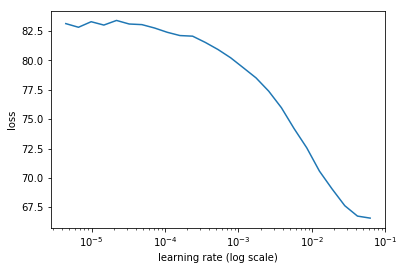

In [516]:
learn.lr_find(lrs / 1000, 1.)
learn.sched.plot(1)

In [517]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20, 10))

epoch      trn_loss   val_loss                            
    0      42.728739  31.723779 
    1      33.468616  29.230579                           
    2      29.280825  27.553922                           
    3      26.502495  26.577007                           
    4      24.343271  25.774259                           


[array([25.77426])]

In [518]:
learn.save('0')

In [333]:
learn.load('0')

### Testing

In [519]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)
learn.model.eval()
batch = learn.model(x)
b_clas, b_bb = batch

In [520]:
b_clas.size(), b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

**Let’s now look at the ground truth `y`.**

In [521]:
idx = 7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima = md.val_ds.ds.denorm(to_np(x))[idx]
bbox, clas = get_y(y[0][idx], y[1][idx])
bbox, clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

**Note:** _the bounding box coordinates have been scaled to between 0 and 1._

In [522]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    """
    We already have `show_ground_truth` function.
    
    This function simply converts tensors into numpy array. (gt stands for ground truth)
    """
    return show_ground_truth(ax, ima, to_np((bbox * 224).long()),
                             to_np(clas), to_np(prs) if prs is not None else None, thresh)

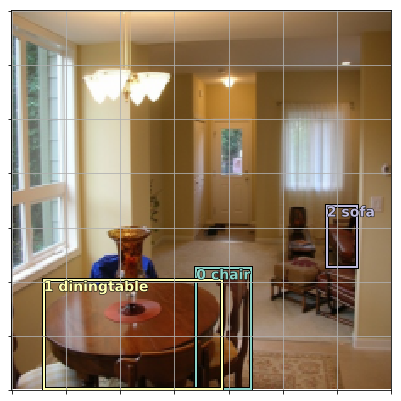

In [523]:
fig, ax = plt.subplots(figsize=(7, 7))
torch_gt(ax, ima, bbox, clas)

The above is a ground truth.

In [541]:
# ============================== DEBUG ==============================
# bbox class

print( b_clasi.size() )
print( b_clasi[0] ) # row 0
print( b_clasi.max(1) ) # for each anchor in the 4x4 grid (axis 1), get the max probs from 21 classes.
print( b_clasi.max(1)[1] ) # get the index of the max probs from the 21 classes

"""
# from left to right, top to bottom of 4x4 grid

 20 <- class id for grid cell 1 (row 1, col 1)
 20 <- class id for grid cell 2 (row 1, col 2)
 20
 20
 20 <- class id for grid cell 5 (row 2, col 1)
 20
 20
 20
  8
  8
  8
  8
  8
  8
  8
  8
"""

# ============================== END DEBUG ==============================

torch.Size([16, 21])
Variable containing:
-7.9409
-8.4019
-7.7694
-7.6277
-7.9959
-8.2181
-8.4665
-7.4942
-6.5471
-8.2714
-7.8436
-8.1778
-7.9276
-8.7532
-7.2732
-5.4202
-7.6146
-7.7791
-7.7715
-7.8431
-2.7875
[torch.cuda.FloatTensor of size 21 (GPU 0)]

(Variable containing:
-2.7875
-2.9035
-3.2043
-3.2724
-2.2851
-2.2383
-2.2714
-2.4146
-2.5406
-0.9353
-0.3087
-2.0451
-1.6821
-0.3948
-0.2443
-2.1207
[torch.cuda.FloatTensor of size 16 (GPU 0)]
, Variable containing:
 20
 20
 20
 20
 20
 20
 20
 20
  8
  8
  8
  8
  8
  8
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]
)
Variable containing:
 20
 20
 20
 20
 20
 20
 20
 20
  8
  8
  8
  8
  8
  8
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]



Here is our 4x4 grid cells from our final convolutional layer.

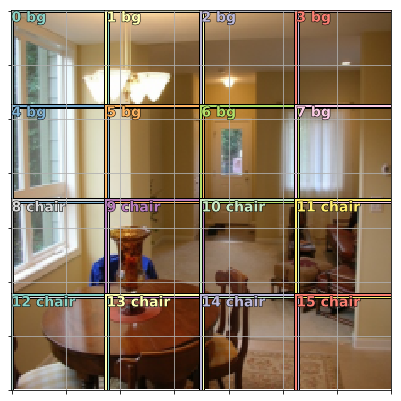

In [525]:
fig, ax = plt.subplots(figsize=(7, 7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

Each of these square boxes, different papers call them different things. The three terms you’ll hear are: anchor boxes, prior boxes, or default boxes. We will stick with the term **anchor boxes**.

What we are going to do for this **loss function** is we are going to go through a **matching problem** where we are going to **take every one of these 16 boxes and see which one of these three ground truth objects has the highest amount of overlap with a given square**.

To do this, we have to have some way of measuring **amount of overlap** and a standard function for this is called **Jaccard index** (IoU).

`IoU = area of overlap / area of union`

In [542]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [373]:
anchors
# first 2 values: center points coords
# last 2 values: grid size

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [548]:
# ============================== DEBUG ==============================
# b_bboxi: activations for bbox in an image

print( type(b_bboxi) ) # PyTorch Variable
print( b_bboxi.size() ) # (16, 4)
print( b_bboxi[0] ) # grid cell activations (bounding boxes)
# ============================== END DEBUG ==============================

<class 'torch.autograd.variable.Variable'>
torch.Size([16, 4])
Variable containing:
 0.2744
 0.2912
-0.3941
-0.7735
[torch.cuda.FloatTensor of size 4 (GPU 0)]



In [549]:
# a_ic: activations image corners
a_ic = actn_to_bb(b_bboxi, anchors)

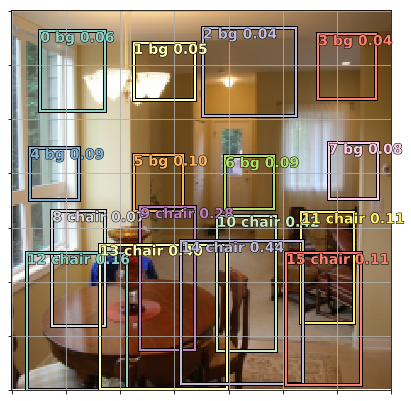

In [550]:
fig, ax = plt.subplots(figsize=(7, 7))

# b_clasi.max(1)[1] -> object class id
# b_clasi.max(1)[0].sigmoid() -> scale class probs using sigmoid
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

We are going to go through and find the Jaccard overlap for each one of the 3 objects versus each of the 16 anchor boxes. That is going to give us a `3x16` matrix.

In [551]:
# Test ssd_1_loss logic
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

What we could do now is we could take the max of dimension (axis) 1 (row-wise) which will tell us for each ground truth object, what the maximum amount that overlaps with some grid cell as well as the index:

In [552]:
overlaps.max(1) # axis 1 -> horizontal (left-to-right)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

We will also going to look at max over a dimension(axis) 0 (column-wise) which will tell us what is the maximum amount of overlap for each grid cell across all of the ground truth objects:

In [553]:
overlaps.max(0) # axis 0 -> vertical (top-to-bottom)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

Here, it tells us for every grid cell what is the index of the ground truth object which overlaps with it the most.

Basically what `map_to_ground_truth` does is it combines these two sets of overlaps in a way described in the **SSD paper** to assign every anchor box to a ground truth object.

The way it assign that is each of the three (row-wise max) gets assigned as is. For the rest of the anchor boxes, they get assigned to anything which they have an overlap of at least 0.5 with (column-wise). If neither applies, it is considered to be a cell which contains background.

Now you can see a list of all the assignments:

In [554]:
# Test ssd_1_loss logic

# ground truth overlap and index
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

Now we can combine these values to classes:

In [555]:
# ground truth class
gt_clas = clas[gt_idx]
gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

Then add a threshold and finally comes up with the three classes that are being predicted:

In [562]:
# Test ssd_1_loss logic

thresh = 0.5
# Get positive indices
pos = gt_overlap > thresh
print(pos)
pos_idx = torch.nonzero(pos)[:, 0]

# Get negative indices
neg_idx = torch.nonzero(1 - pos)[:, 0]
print(neg_idx)

print(pos_idx)


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 1
 1
 0
[torch.cuda.ByteTensor of size 16 (GPU 0)]


  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 12
 15
[torch.cuda.LongTensor of size 13 (GPU 0)]


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]



And here are what each of these anchor boxes is meant to be predicting:

In [567]:
# flip negative class to bg class id
gt_clas[1 - pos] = len(id2cat) # len id2cat is 20
print(gt_clas.data)
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]


 20
 20
 20
 20
 20
 20
 20
 20
 20
 20
 20
 17
 20
 10
  8
 20
[torch.cuda.LongTensor of size 16 (GPU 0)]



['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

So that was the matching stage.

For **L1 loss**, we can:

1. take the activations which matched (`pos_idx = [11, 13, 14]`).
2. subtract from those the ground truth bounding boxes.
3. take the absolute value of the difference.
4. take the mean of that.

For classifications, we can just do a cross entropy.

In [571]:
# Test ssd_1_loss logic
gt_bbox = bbox[gt_idx]
loc_loss = ( ( a_ic[pos_idx] - gt_bbox[pos_idx] ).abs() ).mean()
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss, clas_loss

(Variable containing:
 1.00000e-02 *
   6.3030
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.9787
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

### Result

We will end up with 16 predicted bounding boxes, most of them will be background. If you are wondering what it predicts in terms of bounding box of background, the answer is it totally ignores it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


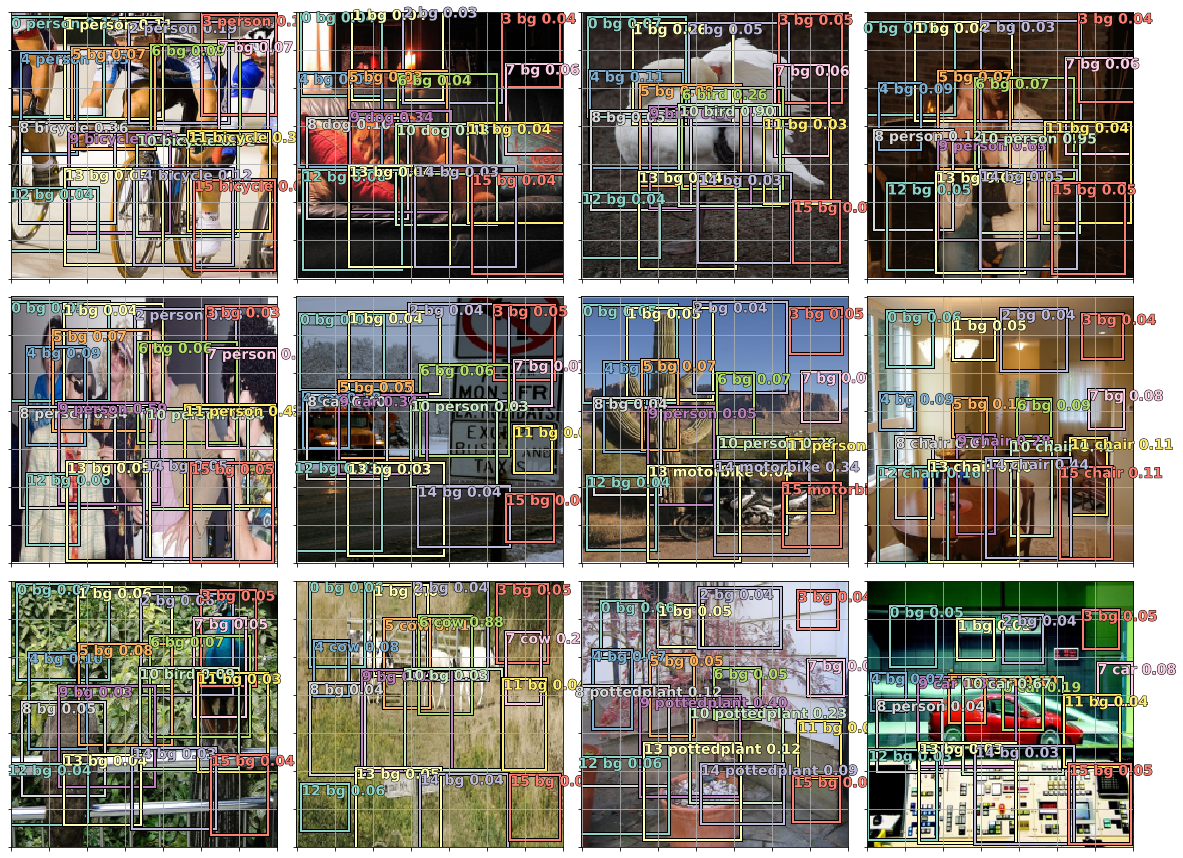

In [572]:
# Plot
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for idx, ax in enumerate(axes.flat):
    # loop through each image out of 12 images
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(bbox, clas); bbox, clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

In practice, we want to remove the background and also add some threshold for probabilities, but it is on the right track. The potted plant image, the result is not surprising as all of our anchor boxes were small (4x4 grid). To go from here to something that is going to be more accurate, all we are going to do is to create way more anchor boxes.

## More anchors!

There are 3 ways to do this:

1. Create anchor boxes of different sizes (zoom).
2. Create anchor boxes of different aspect ratios.
3. Use more convolutional layers as sources of anchor boxes (the boxes are randomly jittered so that we can see ones that are overlapping.

Combining these approaches, you can create lots of anchor boxes.

### Create anchors

In [ ]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

In [ ]:
anc_grids = [4, 2, 1]
# anc_grids = [2]
anc_zoom = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]
# anc_ratios = [(1., 1.)]
anchor